# Fake Account


In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gender_guesser.detector as gender
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import joblib
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

In [2]:
# Path to data folder (relative to project root)
folder = os.path.join(os.path.dirname(os.getcwd()), 'data')
# Exclude the output file from reading
files = [f for f in os.listdir(folder) if f.endswith(".csv") and f != "merged_dataset.csv" and f != "labeled_dataset.csv"]
print(f"Data folder: {folder}")
print(f"Number of files: {len(files)}")
print(f"Files: {files}")

Data folder: d:\university\project grad\ml project 2\data
Number of files: 16
Files: ['fusers.csv', 'labeled_dataset_new.csv', 'synthetic_fake_accounts_strict.csv', 'synthetic_fake_accounts_strict_2000.csv', 'synthetic_fake_accounts_strict_2000_v2.csv', 'twibot20_clean.csv', 'users.csv', 'users1.csv', 'users2.csv', 'users3.csv', 'users4.csv', 'users5.csv', 'users6.csv', 'users7.csv', 'users8.csv', 'users9.csv']


In [3]:
# Discover all files and their dataset values

file_info = []
for file in files:
    path = os.path.join(folder, file)
    temp_df = pd.read_csv(path, nrows=100)
    
    dataset_val = None
    if 'dataset' in temp_df.columns:
        dataset_val = temp_df['dataset'].unique()[0]
    
    file_info.append({
        'file': file,
        'rows': len(pd.read_csv(path)),
        'dataset_value': dataset_val,
        'columns': len(temp_df.columns)
    })
    print(f"{file}: {file_info[-1]['rows']} rows, dataset = {dataset_val}")

# Summary
print("\n" + "=" * 50)
print("SUMMARY:")
print("=" * 50)
info_df = pd.DataFrame(file_info)
print(info_df)

fusers.csv: 1337 rows, dataset = INT
labeled_dataset_new.csv: 21058 rows, dataset = None
synthetic_fake_accounts_strict.csv: 5000 rows, dataset = None
synthetic_fake_accounts_strict_2000.csv: 2000 rows, dataset = None
synthetic_fake_accounts_strict_2000_v2.csv: 2000 rows, dataset = None
twibot20_clean.csv: 100 rows, dataset = None
users.csv: 1481 rows, dataset = E13
users1.csv: 1169 rows, dataset = FSF
users2.csv: 464 rows, dataset = None
users3.csv: 469 rows, dataset = TFP
users4.csv: 845 rows, dataset = TWT
users5.csv: 1128 rows, dataset = None
users6.csv: 3351 rows, dataset = None
users7.csv: 3474 rows, dataset = None
users8.csv: 991 rows, dataset = None
users9.csv: 3457 rows, dataset = None

SUMMARY:
                                          file   rows dataset_value  columns
0                                   fusers.csv   1337           INT       34
1                      labeled_dataset_new.csv  21058          None        6
2           synthetic_fake_accounts_strict.csv   5000  

In [12]:
# Define which files are FAKE (bots) and which are REAL (humans)
# [fusers,twibot20] = fake users (bots)
# users* = real users (humans)

fake_files = ['fusers.csv', 'twibot20_clean.csv','synthetic_fake_accounts_strict.csv','synthetic_fake_accounts_strict_2000_v2.csv','synthetic_fake_accounts_strict_2000.csv']

real_files = [f for f in files if f.startswith('users')]

print("FAKE files (bots):", fake_files)
print("REAL files (humans) with dataset values:", real_files)


FAKE files (bots): ['fusers.csv', 'twibot20_clean.csv', 'synthetic_fake_accounts_strict.csv', 'synthetic_fake_accounts_strict_2000_v2.csv', 'synthetic_fake_accounts_strict_2000.csv']
REAL files (humans) with dataset values: ['users.csv', 'users1.csv', 'users2.csv', 'users3.csv', 'users4.csv', 'users5.csv', 'users6.csv', 'users7.csv', 'users8.csv', 'users9.csv']


In [13]:
# Re-read and merge with labels
dfs_labeled = []

# Read FAKE files (label = 1)
for file in fake_files:
    path = os.path.join(folder, file)
    df = pd.read_csv(path)
    df['label'] = 1  # FAKE/BOT
    dfs_labeled.append(df)
    print(f"{file}: {len(df)} fake accounts")

# Read REAL files (label = 0)
for file in real_files:
    path = os.path.join(folder, file)
    df = pd.read_csv(path)
    df['label'] = 0  # REAL/HUMAN
    dfs_labeled.append(df)
    print(f"{file}: {len(df)} real accounts")

fusers.csv: 1337 fake accounts
twibot20_clean.csv: 100 fake accounts
synthetic_fake_accounts_strict.csv: 5000 fake accounts
synthetic_fake_accounts_strict_2000_v2.csv: 2000 fake accounts
synthetic_fake_accounts_strict_2000.csv: 2000 fake accounts
users.csv: 1481 real accounts
users1.csv: 1169 real accounts
users2.csv: 464 real accounts
users3.csv: 469 real accounts
users4.csv: 845 real accounts
users5.csv: 1128 real accounts
users6.csv: 3351 real accounts
users7.csv: 3474 real accounts
users8.csv: 991 real accounts
users9.csv: 3457 real accounts


In [14]:
# Find common columns (including 'label')
common_cols = set(dfs_labeled[0].columns)
for df in dfs_labeled[1:]:
    common_cols = common_cols.intersection(set(df.columns))
common_cols = list(common_cols)

# Make sure 'label' is included
if 'label' not in common_cols:
    common_cols.append('label')

print(f"Common columns: {common_cols}")

Common columns: ['friends_count', 'favourites_count', 'followers_count', 'label', 'verified', 'listed_count']


In [15]:
# Merge all dataframes
dfs_filtered = [df[common_cols] for df in dfs_labeled]
final_df = pd.concat(dfs_filtered, ignore_index=True)

# Remove duplicates
final_df.drop_duplicates(inplace=True)

# Save to data folder
output_path = os.path.join(folder, "labeled_dataset_new.csv")
final_df.to_csv(output_path, index=False)

print("Dataset with labels created!")
print(f"Saved to: {output_path}")
print(f"Total rows: {len(final_df)}")
print(f"Fake accounts: {len(final_df[final_df['label'] == 1])}")
print(f"Real accounts: {len(final_df[final_df['label'] == 0])}")
print(f"Columns: {common_cols}")
print("=" * 50)
print("\nLabel distribution:")
print(final_df['label'].value_counts())

Dataset with labels created!
Saved to: d:\university\project grad\ml project 2\data\labeled_dataset_new.csv
Total rows: 21058
Fake accounts: 10270
Real accounts: 10788
Columns: ['friends_count', 'favourites_count', 'followers_count', 'label', 'verified', 'listed_count']

Label distribution:
label
0    10788
1    10270
Name: count, dtype: int64


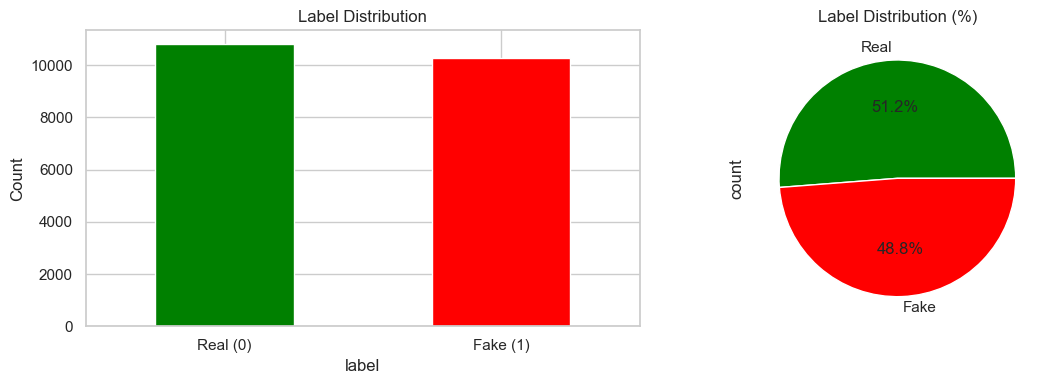

In [16]:
# Load the labeled dataset
df = pd.read_csv(output_path)

# Show class distribution


fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
df['label'].value_counts().plot(kind='bar', ax=ax[0], color=['green', 'red'])
ax[0].set_title('Label Distribution')
ax[0].set_xticklabels(['Real (0)', 'Fake (1)'], rotation=0)
ax[0].set_ylabel('Count')

# Pie chart
df['label'].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', 
                                  colors=['green', 'red'], labels=['Real', 'Fake'])
ax[1].set_title('Label Distribution (%)')

plt.tight_layout()
plt.show()

In [17]:
# Efficient predict_sex that can be applied to a Series
detector = gender.Detector(case_sensitive=False)
def predict_sex(name):
    # Defensive: handle NaN / non-string
    try:
        first_name = str(name).strip().split(' ')[0]
        sex = detector.get_gender(first_name)
    except Exception:
        sex = 'unknown'
    mapping = {'female': -2, 'mostly_female': -1, 'unknown': 0, 'andy': 0, 'mostly_male': 1, 'male': 2}
    return mapping.get(sex, 0)

In [18]:
def read_and_preprocess(data_path='data/labeled_dataset.csv'):
    """
    Read and preprocess the labeled dataset with NEW ENHANCED FEATURES.
    These features significantly improve fake account detection accuracy.
    """
    import re
    
    # Read the labeled dataset
    df = pd.read_csv(data_path)
    
    # Get labels from the 'label' column (1 = fake, 0 = real)
    y = df['label'].values
    
    # Basic cleaning: remove exact duplicates if any
    df = df.drop_duplicates().reset_index(drop=True)
    y = df['label'].values  # Update y after dropping duplicates

    # ============================================
    # BASIC NUMERIC FEATURES
    # ============================================
    numeric_cols = ['statuses_count','followers_count','friends_count','favourites_count','listed_count']
    for c in numeric_cols:
        if c not in df.columns:
            df[c] = 0
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(float)

    # Language encoding (robust)
    if 'lang' in df.columns:
        langs = df['lang'].fillna('unknown').astype(str)
        df['lang_code'] = pd.factorize(langs)[0]
    else:
        df['lang_code'] = 0

    # Sex code using apply
    if 'name' in df.columns:
        df['sex_code'] = df['name'].apply(predict_sex)
    else:
        df['sex_code'] = 0

    # account_age_days and tweets_per_day
    if 'created_at' in df.columns:
        try:
            created = pd.to_datetime(df['created_at'], errors='coerce')
            now = pd.Timestamp.now()
            df['account_age_days'] = (now - created).dt.total_seconds().div(3600*24).fillna(0)
            df['tweets_per_day'] = df['statuses_count'] / (df['account_age_days'].replace(0, np.nan))
            df['tweets_per_day'] = df['tweets_per_day'].replace([np.inf, -np.inf], 0).fillna(0)
        except Exception:
            df['account_age_days'] = 0
            df['tweets_per_day'] = 0
    else:
        df['account_age_days'] = 0
        df['tweets_per_day'] = 0

    # description length
    if 'description' in df.columns:
        df['description_length'] = df['description'].fillna('').astype(str).apply(len)
    else:
        df['description_length'] = 0

    # Helper function to convert boolean-like columns
    def to_bool_int(series):
        return series.fillna(0).astype(str).str.strip().str.lower().map(
            {'true': 1, 'false': 0, '1': 1, '0': 0, '1.0': 1, '0.0': 0}
        ).fillna(0).astype(int)

    # default_profile, verified flags
    if 'default_profile' in df.columns:
        df['default_profile'] = to_bool_int(df['default_profile'])
    else:
        df['default_profile'] = 0
        
    if 'verified' in df.columns:
        df['verified'] = to_bool_int(df['verified'])
    else:
        df['verified'] = 0

    # ============================================
    # NEW ENHANCED FEATURES FOR FAKE DETECTION
    # ============================================
    
    # --- RATIO FEATURES (Most Important!) ---
    # Followers to Friends ratio (Real users: ~1.0, Bots: very low)
    df['followers_to_friends_ratio'] = np.where(
        df['friends_count'] > 0,
        df['followers_count'] / df['friends_count'],
        df['followers_count']
    ).clip(0, 100)
    
    # Friends to Followers ratio (inverse - high value = suspicious)
    df['friends_to_followers_ratio'] = np.where(
        df['followers_count'] > 0,
        df['friends_count'] / df['followers_count'],
        df['friends_count']
    ).clip(0, 100)
    
    # Engagement ratio: favorites / statuses
    df['engagement_ratio'] = np.where(
        df['statuses_count'] > 0,
        df['favourites_count'] / df['statuses_count'],
        0
    ).clip(0, 100)
    
    # Reputation score: followers / (followers + friends)
    total = df['followers_count'] + df['friends_count']
    df['reputation_score'] = np.where(total > 0, df['followers_count'] / total, 0.5)
    
    # Listed ratio: listed_count / followers
    df['listed_ratio'] = np.where(
        df['followers_count'] > 0,
        df['listed_count'] / df['followers_count'],
        0
    ).clip(0, 10)
    
    # Favorites per tweet
    df['favorites_per_tweet'] = np.where(
        df['statuses_count'] > 0,
        df['favourites_count'] / df['statuses_count'],
        0
    ).clip(0, 100)
    
    # --- NAME FEATURES ---
    if 'name' in df.columns:
        df['name_length'] = df['name'].fillna('').astype(str).apply(len)
        df['has_digits_in_name'] = df['name'].fillna('').astype(str).apply(
            lambda x: 1 if re.search(r'\d', x) else 0
        )
    else:
        df['name_length'] = 0
        df['has_digits_in_name'] = 0
    
    if 'screen_name' in df.columns:
        df['screen_name_length'] = df['screen_name'].fillna('').astype(str).apply(len)
        df['digit_ratio_in_screen_name'] = df['screen_name'].fillna('').apply(
            lambda s: sum(c.isdigit() for c in str(s)) / max(len(str(s)), 1)
        )
    else:
        df['screen_name_length'] = 0
        df['digit_ratio_in_screen_name'] = 0
    
    # Has URL in profile
    if 'url' in df.columns:
        df['has_url'] = df['url'].fillna('').astype(str).apply(
            lambda x: 1 if len(x) > 0 and x.lower() not in ['nan', 'null', 'none', ''] else 0
        )
    else:
        df['has_url'] = 0
    
    # Has description
    if 'description' in df.columns:
        df['has_description'] = df['description'].fillna('').astype(str).apply(
            lambda x: 1 if len(x.strip()) > 0 else 0
        )
    else:
        df['has_description'] = 0
    
    # --- SUSPICIOUS PATTERNS ---
    # Is new account (< 30 days)
    df['is_new_account'] = (df['account_age_days'] < 30).astype(int)
    
    # Zero followers
    df['zero_followers'] = (df['followers_count'] == 0).astype(int)
    
    # Zero statuses
    df['zero_statuses'] = (df['statuses_count'] == 0).astype(int)
    
    # Following many but no followers (classic bot pattern)
    df['following_many_no_followers'] = (
        (df['friends_count'] > 100) & (df['followers_count'] < 10)
    ).astype(int)
    
    # High friend rate
    df['high_friend_rate'] = np.where(
        df['account_age_days'] > 0,
        df['friends_count'] / df['account_age_days'],
        df['friends_count']
    ).clip(0, 100)

    # ============================================
    # SELECT ALL FEATURES
    # ============================================
    features = [
        # Basic counts
        'statuses_count', 'followers_count', 'friends_count', 
        'favourites_count', 'listed_count',
        # Encoded features
        'sex_code', 'lang_code',
        # Activity metrics
        'tweets_per_day', 'account_age_days',
        # Profile features
        'description_length', 'default_profile', 'verified',
        # NEW: Ratio features
        'followers_to_friends_ratio', 'friends_to_followers_ratio',
        'engagement_ratio', 'reputation_score', 'listed_ratio', 'favorites_per_tweet',
        # NEW: Name features
        'name_length', 'screen_name_length', 'has_digits_in_name',
        'digit_ratio_in_screen_name', 'has_url', 'has_description',
        # NEW: Suspicious patterns
        'is_new_account', 'zero_followers', 'zero_statuses',
        'following_many_no_followers', 'high_friend_rate',
    ]
    features = [f for f in features if f in df.columns]

    X = df.loc[:, features].copy()
    X = X.fillna(0)
    
    print(f"Total features: {len(features)}")
    print(f"Features: {features}")

    return X, y, df

## Modeling: hyperparameter tuning and evaluation


In [19]:

# Load the labeled dataset
df = pd.read_csv(output_path)

# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)
y = df['label'].values

print(f"Dataset shape: {df.shape}")
print(f"Label distribution: Fake (1)={sum(y==1)}, Real (0)={sum(y==0)}")

# Train/Test split on the full DataFrame (not just features)
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.25, random_state=42, stratify=y
)

print(f"\nTrain size: {len(X_train)}, Test size: {len(X_test)}")

# Import FeatureEngineer from src (with reload to get latest changes)
import sys
import importlib
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

# Force reload to get the latest changes
if 'feature_engineer' in sys.modules:
    importlib.reload(sys.modules['feature_engineer'])
from feature_engineer import FeatureEngineer

# Pipeline with FeatureEngineer, Scaler, and Classifier
pipeline = Pipeline([
    ('fe', FeatureEngineer()),
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Parameter grid
param_grid = {
    'clf__n_estimators': [200, 300, 500],
    'clf__max_depth': [10, 20, 30],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2'],
}

# GridSearchCV
gs = GridSearchCV(
    pipeline, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    scoring='accuracy',
    verbose=2
)

gs.fit(X_train, y_train)

# Results
best_pipeline = gs.best_estimator_
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:,1]

print('\n' + '='*50)
print('Best params:', gs.best_params_)
print(f'Best CV Accuracy: {gs.best_score_:.4f}')
print('='*50)
print(f'Test Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'Test ROC AUC: {roc_auc_score(y_test, y_proba):.4f}')
print('='*50)
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Real (0)', 'Fake (1)']))

Dataset shape: (21058, 6)
Label distribution: Fake (1)=10270, Real (0)=10788

Train size: 15793, Test size: 5265
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best params: {'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best CV Accuracy: 0.9269
Test Accuracy: 0.9231
Test ROC AUC: 0.9857

Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.89      0.97      0.93      2697
    Fake (1)       0.96      0.88      0.92      2568

    accuracy                           0.92      5265
   macro avg       0.93      0.92      0.92      5265
weighted avg       0.93      0.92      0.92      5265



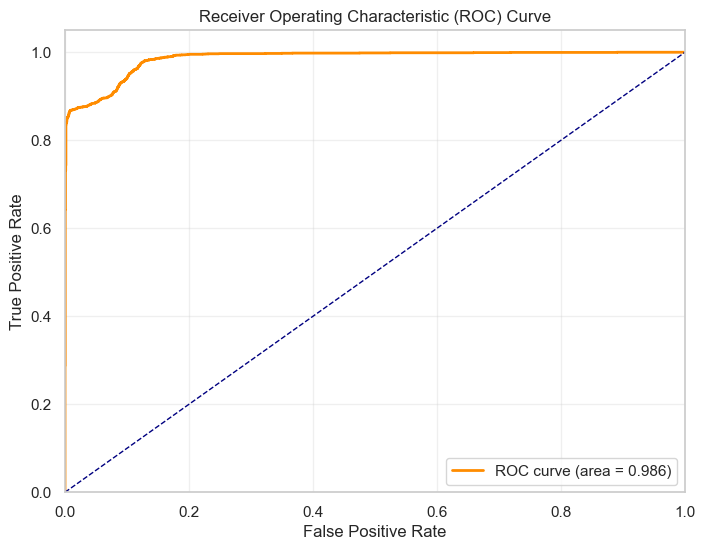

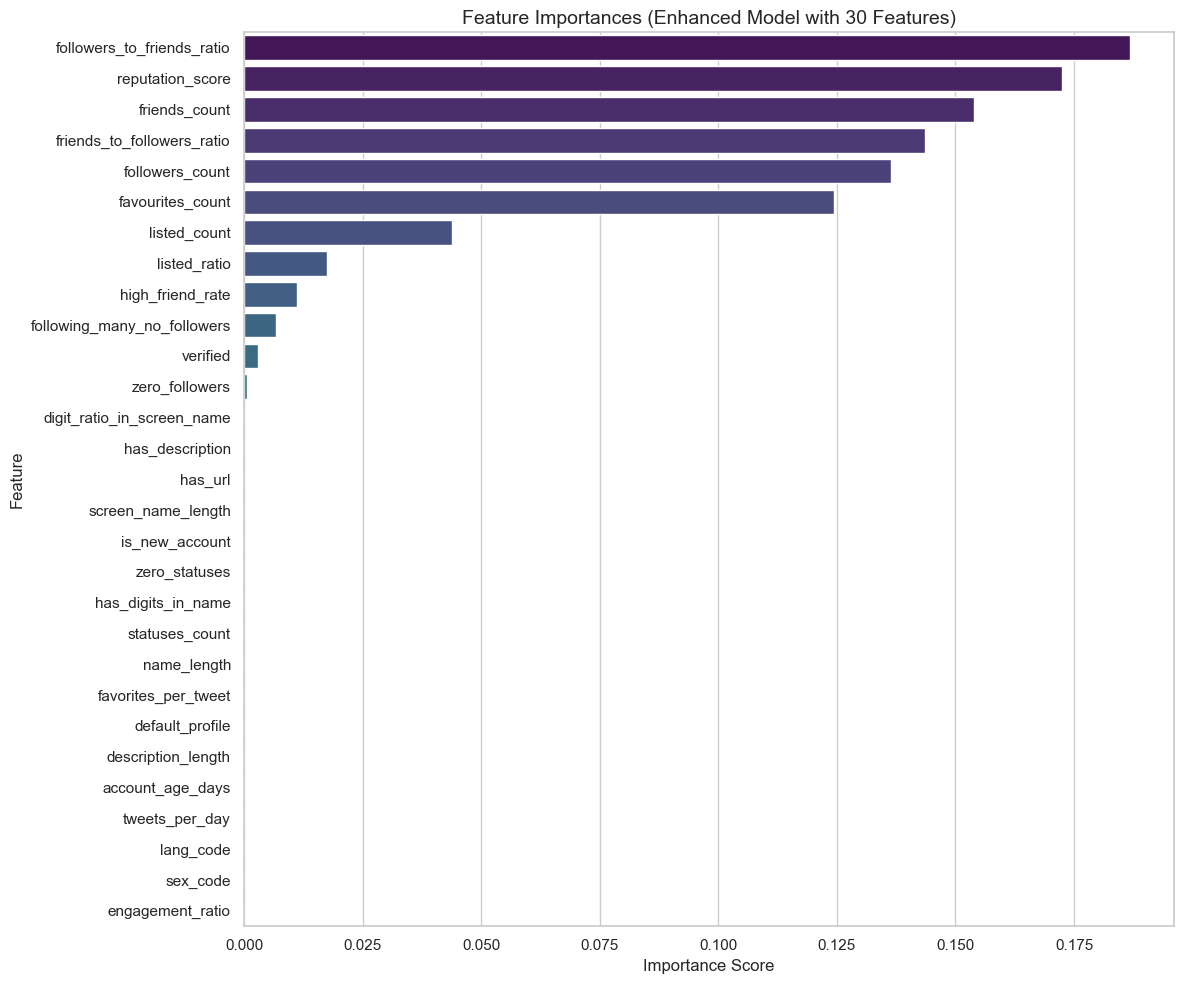


TOP 15 MOST IMPORTANT FEATURES:
 1. followers_to_friends_ratio          : 0.1867
 2. reputation_score                    : 0.1725
 3. friends_count                       : 0.1539
 4. friends_to_followers_ratio          : 0.1436
 5. followers_count                     : 0.1364
 6. favourites_count                    : 0.1244
 7. listed_count                        : 0.0438
 8. listed_ratio                        : 0.0174
 9. high_friend_rate                    : 0.0111
10. following_many_no_followers         : 0.0067
11. verified                            : 0.0029
12. zero_followers                      : 0.0005
13. digit_ratio_in_screen_name          : 0.0000
14. has_description                     : 0.0000
15. has_url                             : 0.0000

Pipeline saved to: d:\university\project grad\ml project 2\models\randomforest_notebook.joblib


In [20]:
# ROC curve and feature importances
if 'y_proba' in globals() and y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

# Feature importances - get classifier from pipeline
best_clf = best_pipeline.named_steps['clf']

# NEW: Updated feature names list with all 30 features
feature_names = [
    # Basic counts
    'statuses_count', 'followers_count', 'friends_count', 
    'favourites_count', 'listed_count',
    # Encoded features
    'sex_code', 'lang_code',
    # Activity metrics
    'tweets_per_day', 'account_age_days',
    # Profile features
    'description_length', 'default_profile', 'verified',
    # NEW: Ratio features (most important for fake detection!)
    'followers_to_friends_ratio', 'friends_to_followers_ratio',
    'engagement_ratio', 'reputation_score', 'listed_ratio', 'favorites_per_tweet',
    # NEW: Name features
    'name_length', 'screen_name_length', 'has_digits_in_name',
    'digit_ratio_in_screen_name', 'has_url', 'has_description',
    # NEW: Suspicious patterns
    'is_new_account', 'zero_followers', 'zero_statuses',
    'following_many_no_followers', 'high_friend_rate',
]

# Match feature names to actual number of features
n_features = len(best_clf.feature_importances_)
if n_features != len(feature_names):
    print(f"Warning: Model has {n_features} features, but {len(feature_names)} names provided")
    feature_names = feature_names[:n_features] if n_features < len(feature_names) else feature_names + [f'feature_{i}' for i in range(len(feature_names), n_features)]

importances = pd.Series(best_clf.feature_importances_, index=feature_names).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 10))
colors = ['#e74c3c' if 'ratio' in f or 'suspicious' in f or 'zero' in f or 'following' in f or 'high_friend' in f 
          else '#3498db' for f in importances.index]
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('Feature Importances (Enhanced Model with 30 Features)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print('\n' + '='*60)
print('TOP 15 MOST IMPORTANT FEATURES:')
print('='*60)
for i, (feat, imp) in enumerate(importances.head(15).items(), 1):
    print(f"{i:2}. {feat:35} : {imp:.4f}")
print('='*60)

# Save the full pipeline
models_dir = os.path.join(os.path.dirname(os.getcwd()), 'models')
os.makedirs(models_dir, exist_ok=True)

model_path = os.path.join(models_dir, 'randomforest_notebook.joblib')
joblib.dump(best_pipeline, model_path)
print(f"\nPipeline saved to: {model_path}")

## Visualizations: Confusion Matrix, ROC, PR, Model Comparison

The following cells plot standard evaluation figures using the `y_test`, `y_pred`, and `y_proba` variables produced earlier in this notebook.

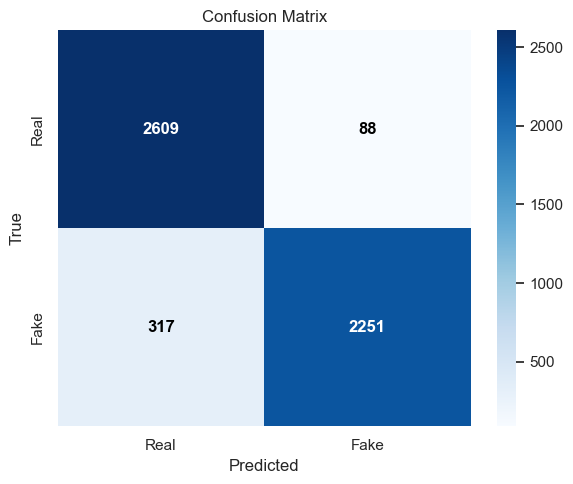

In [23]:
# 1) Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

if 'y_test' not in globals() or 'y_pred' not in globals():
    raise ValueError('Run the modeling cells first to obtain y_test and y_pred')

out_dir = os.path.join(os.path.dirname(os.getcwd()), 'docs', 'figures')
os.makedirs(out_dir, exist_ok=True)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real','Fake'], yticklabels=['Real','Fake'], cbar=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
# Improve annotation contrast
try:
    texts = ax.texts
    thresh = cm.max() / 2.0 if cm.size else 0
    for t, val in zip(texts, cm.flatten()):
        t.set_color('white' if val > thresh else 'black')
        t.set_fontweight('bold')
except Exception:
    pass
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(out_dir, 'confusion_matrix_notebook.png'), dpi=150)
plt.close()

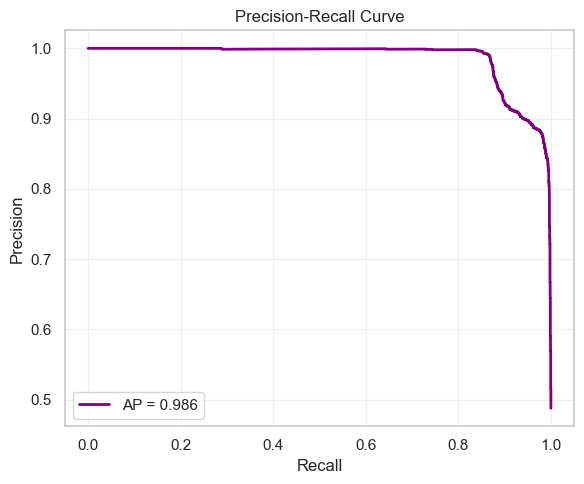

In [25]:
# 3) Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import os

if 'y_proba' in globals() and y_proba is not None:
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, color='purple', lw=2, label=f'AP = {ap:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(out_dir, 'pr_curve_notebook.png'), dpi=150)
    plt.close()
else:
    print('y_proba not available; skipping PR curve')